# Mini-Lab: Logistic Regression and SVMs ¶
Allen Ansari, Chad Madding and Yongjun (Ian) Chu

## 1. Data preprocessing (from Lab 1)

In [1]:
import pandas as pd
import numpy as np
import copy
import seaborn as sns

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

matplotlib.style.use('ggplot')

import warnings
warnings.simplefilter('ignore', DeprecationWarning)
warnings.simplefilter('ignore', FutureWarning)

from pandas.plotting import scatter_matrix

#Bring in data set
df = pd.read_csv('data/cardio_train.csv', sep=';') #read in the csv file

# Show the dimention and the first 5 rows of the dataset
print(df.shape)
df.head()

(70000, 13)


,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0


In [2]:
# drop 'id' column 
if 'id' in df:
    del df['id']

#df.drop('id',axis=1,inplace=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 12 columns):
age            70000 non-null int64
gender         70000 non-null int64
height         70000 non-null int64
weight         70000 non-null float64
ap_hi          70000 non-null int64
ap_lo          70000 non-null int64
cholesterol    70000 non-null int64
gluc           70000 non-null int64
smoke          70000 non-null int64
alco           70000 non-null int64
active         70000 non-null int64
cardio         70000 non-null int64
dtypes: float64(1), int64(11)
memory usage: 6.4 MB


In [3]:
# Total missing values for each feature
df.isnull().sum()
df.isnull().values.any()

False

In [4]:
# Are there any non-numbers in each column?
for column in df:
    print(column)
    cnt=0
    for row in df[column]:
        try:
            float(row)
            #df.loc[cnt, 'ap_lo']=row
        except ValueError:
            print("there is a non-numeric value: " + row)
            pass
        cnt+=1
        
print(cnt)

age
gender
height
weight
ap_hi
ap_lo
cholesterol
gluc
smoke
alco
active
cardio
70000


In [5]:
#Are there any duplicate entries in the dataset?
#duplicateRowsDF = df[df.duplicated(keep=False)]
duplicateRowsDF = df[df.duplicated(keep='first')]

print("Duplicate Rows except first occurrence based on all columns are :")
print(duplicateRowsDF)

print(f"\nThere are {len(duplicateRowsDF)} duplicated entries in the dataset!")


Duplicate Rows except first occurrence based on all columns are :
         age  gender  height  weight  ap_hi  ap_lo  cholesterol  gluc  smoke  \
10562  20495       1     165    70.0    120     80            1     1      0   
21784  16793       1     165    68.0    120     80            1     1      0   
38505  18988       1     164    65.0    120     80            1     1      0   
40365  14552       1     158    64.0    120     80            1     1      0   
42450  18353       1     169    67.0    120     80            1     1      0   
44653  16937       2     170    70.0    120     80            1     1      0   
45125  21280       1     165    65.0    120     80            1     1      0   
45748  22077       1     175    69.0    120     80            1     1      0   
45810  21230       1     164    62.0    120     80            1     1      0   
48917  21945       1     165    60.0    120     80            1     1      0   
50432  17493       2     169    74.0    120     80    

In [6]:
#remove duplicates in the dataframe
df.drop_duplicates(keep = 'first', inplace = True) 
df.shape

(69976, 12)

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
count,69976.000000,69976.000000,69976.000000,69976.000000,69976.000000,69976.000000,69976.000000,69976.000000,69976.000000,69976.000000,69976.000000,69976.000000
mean,19468.950126,1.349648,164.359152,74.208519,128.820453,96.636261,1.366997,1.226535,0.088159,0.053790,0.803718,0.499771
std,2467.374620,0.476862,8.211218,14.397211,154.037729,188.504581,0.680333,0.572353,0.283528,0.225604,0.397187,0.500004
min,10798.000000,1.000000,55.000000,10.000000,-150.000000,-70.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,17664.000000,1.000000,159.000000,65.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
50%,19703.000000,1.000000,165.000000,72.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
75%,21327.000000,2.000000,170.000000,82.000000,140.000000,90.000000,2.000000,1.000000,0.000000,0.000000,1.000000,1.000000
max,23713.000000,2.000000,250.000000,200.000000,16020.000000,11000.000000,3.000000,3.000000,1.000000,1.000000,1.000000,1.000000


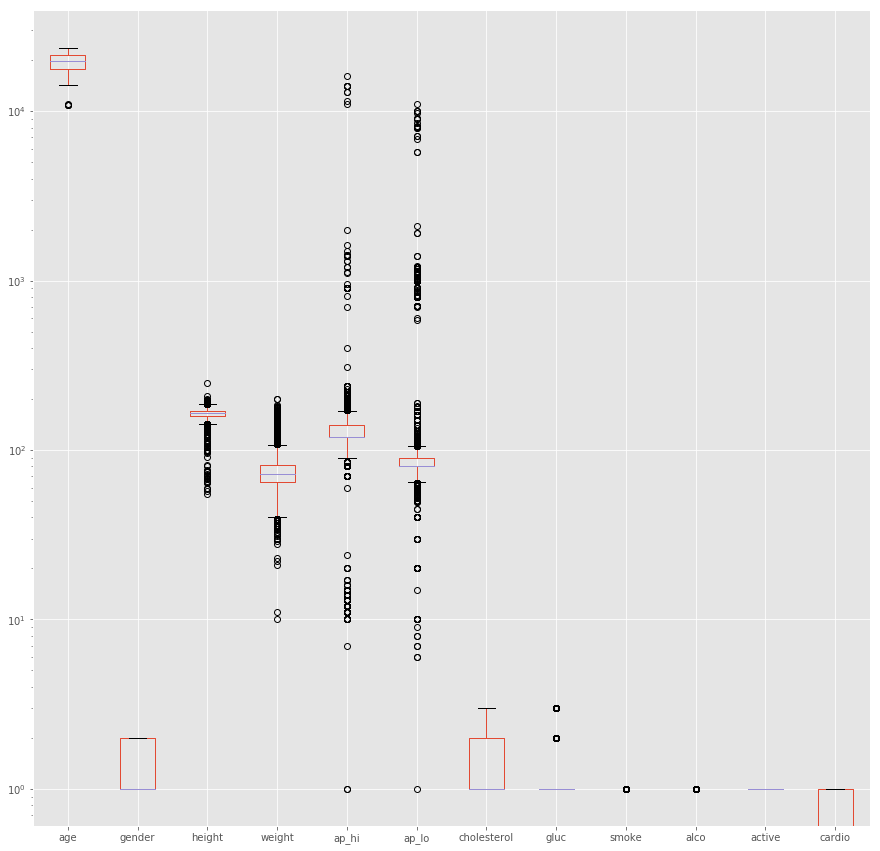

In [7]:
#are there any outliers in the dataset?

#boxplot of all the varibles
plt.figure(figsize=(15, 15))
ax = df.boxplot()
ax.set_yscale('log')

df.describe()

#There are outliners (sometimes wrong entries) within multiple attributes. 

In [8]:
#to only keep the entries between 97.5% quantile and 2.5% quantile for ap_hi and ap_lo
df.drop(df[(df['ap_hi'] > df['ap_hi'].quantile(0.975)) | (df['ap_hi'] < df['ap_hi'].quantile(0.025))].index,inplace=True)
df.drop(df[(df['ap_lo'] > df['ap_lo'].quantile(0.975)) | (df['ap_lo'] < df['ap_lo'].quantile(0.025))].index,inplace=True)
df.shape

(66169, 12)

In [9]:
#to find how many rows where the Diastilic pressure is higher than systolic one, which is obviously impossible in reality.
print(df.shape)
print("Diastilic pressure is higher than systolic one in {0} cases".format(df[df['ap_lo']> df['ap_hi']].shape[0]))

(66169, 12)
Diastilic pressure is higher than systolic one in 0 cases


In [10]:
df.drop(df[(df['weight'] > df['weight'].quantile(0.975)) | (df['weight'] < df['weight'].quantile(0.025))].index,inplace=True)

print(df.shape)

(63055, 12)


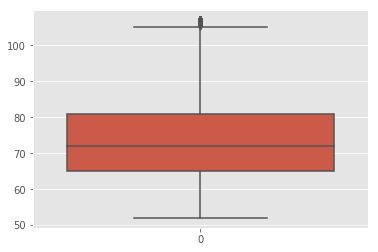

In [11]:
#boxplot to see the distribution of "weight"
sns.boxplot(data = df["weight"])

In [12]:
#we want to check how the plot looks like when converting age from days to years
if 'age' in df:
    df['years'] = (df['age'] / 365).round().astype('int')

if 'age' in df:
    del df['age']

Body mass index (BMI) is commonly used in medical field. It is a key index for relating weight to height. BMI is a person's weight in kilograms (kg) divided by his or her height in meters squared.

In [13]:
#define BMI
df['BMI'] = df['weight']/((df['height']/100)**2)
# converting BMI range to categorical as 1 = underweight,2 = normal, 3 = overweight and 4 = obese
df['BMI'] = df['BMI'].apply(lambda x: 1 if x<18.5 else(2 if x>=18.5 and x<25 else( 3 if x >= 25 and x < 30 else 4)))

In [14]:
#change gender levels: 1 to 0 (female) and 2 to 1 (male)
df['gender'] = df['gender'].apply(lambda x:0 if x == 1 else(1))
#print(str(df['gender']))
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 63055 entries, 0 to 69999
Data columns (total 13 columns):
gender         63055 non-null int64
height         63055 non-null int64
weight         63055 non-null float64
ap_hi          63055 non-null int64
ap_lo          63055 non-null int64
cholesterol    63055 non-null int64
gluc           63055 non-null int64
smoke          63055 non-null int64
alco           63055 non-null int64
active         63055 non-null int64
cardio         63055 non-null int64
years          63055 non-null int32
BMI            63055 non-null int64
dtypes: float64(1), int32(1), int64(11)
memory usage: 9.0 MB


## 2. Create Models

### A. Logistic Regression

#### A1. Initial model build

In [15]:
#separating data into two parts X (features) and Y (target)
features = ["gender", "height", "weight", "ap_hi", "ap_lo", "cholesterol", "gluc", "smoke", "alco", "active", "years", "BMI"]
# Separating out the features
X = df.loc[:, features].values

#Separating out the target
Y = df.loc[:, ['cardio']].values.ravel()

In [16]:
#Building a logistic regression model with default values for parameters

#apply cross validation, using 80/20 train/test splitting
from sklearn.model_selection import ShuffleSplit
cv = ShuffleSplit(n_splits=2, test_size=0.20, random_state=0)

#apply standard scaling: to standard normally distributed data
from sklearn.preprocessing import StandardScaler
scl_obj = StandardScaler()

from sklearn import metrics as mt
#apply logistic regression
from sklearn.linear_model import LogisticRegression
regEstimator = LogisticRegression()


for train_indices, test_indices in cv.split(X,Y): 
    X_train = X[train_indices]
    Y_train = Y[train_indices]
    
    X_test = X[test_indices]
    Y_test = Y[test_indices] 
    
    X_train_scaled = scl_obj.fit_transform(X_train) # apply to training
    X_test_scaled = scl_obj.transform(X_test) 
    
    regEstimator.fit(X_train_scaled, Y_train)  # train object
    y_hat = regEstimator.predict(X_test_scaled) # get test set precitions
    acc = mt.accuracy_score(Y_test,y_hat)
    conf = mt.confusion_matrix(Y_test,y_hat)
    print('accuracy:', acc )
    print(conf)

accuracy: 0.7222266275473793
[[5060 1384]
 [2119 4048]]
accuracy: 0.7199270478153993
[[4966 1332]
 [2200 4113]]


Using default values for logistic regression model, we obtained an accuracy value around 72%. Can we increase the accuracy by optimizing the parameter value settings?

#### A2. Find the best logistic regression parameter settings

In [17]:
#divide data into two parts X(features) and Y(target)
df_1 = df.copy()
X = df_1[features].copy()

Y= df_1[['cardio']].copy()

In [18]:
#Divide data into test and training splits and having 10-fold CV
cv = ShuffleSplit(n_splits=10, test_size=0.20, random_state=0)

In [19]:
#Classifier Evaluation

from sklearn.model_selection import cross_validate

def EvaluateClassifierEstimator(classifierEstimator, X, Y, cv):
   
    #Perform cross validation 
    scores = cross_validate(classifierEstimator, X, Y, scoring=['accuracy','precision']
                            , cv=cv, return_train_score=True)

    Accavg = scores['test_accuracy'].mean()
    Preavg = scores['test_precision'].mean()

    print_str = "The average accuracy for all cv folds is: \t\t\t {Accavg:.5}"
    print_str2 = "The average precision for all cv folds is: \t\t\t {Preavg:.5}"


    print(print_str.format(Accavg=Accavg))
    print(print_str2.format(Preavg=Preavg))
    print('*********************************************************')

    print('Cross Validation Fold Mean Error Scores')
    scoresResults = pd.DataFrame()
    scoresResults['Accuracy'] = scores['test_accuracy']
    scoresResults['Precision'] = scores['test_precision']

    return scoresResults

def EvaluateClassifierEstimator2(classifierEstimator, X, Y, cv):
    
    #Perform cross validation 
    from sklearn.model_selection import cross_val_predict
    predictions = cross_val_predict(classifierEstimator, X, Y, cv=cv)
    
    #model evaluation 
    from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
    
    #pass true test set values and predictions to classification_report
    classReport = classification_report(Y,predictions)
    confMat = confusion_matrix(Y,predictions)
    acc = accuracy_score(Y,predictions)
    
    print(classReport)
    print(confMat)
    print(acc)

In [20]:
#data scaling
scaler = StandardScaler()
scaler.fit(X)

#Transform training data to z-scores
#This makes our model's coefficients take on the same scale for accurate feature importance analysis 
X_Scl = scaler.transform(X)

In [21]:
#Logisitic regression 10-fold cross-validation 

regEstimator = LogisticRegression()

parameters = { 'penalty':['l2']
              ,'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]
              ,'class_weight': ['balanced','none']
              ,'random_state': [0]
              ,'solver': ['lbfgs']
              ,'max_iter':[100,500]
             }

#Create a grid search object using the above parameters 
from sklearn.model_selection import GridSearchCV
regGridSearch = GridSearchCV(estimator=regEstimator
                   , n_jobs=8 # jobs to run in parallel
                   , verbose=1 # low verbosity
                   , param_grid=parameters
                   , cv=cv # KFolds = 10
                   , scoring='accuracy')

#Perform hyperparameter search to find the best combination of parameters for our data
regGridSearch.fit(X_Scl, Y)

Fitting 10 folds for each of 28 candidates, totalling 280 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    4.4s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    9.8s
[Parallel(n_jobs=8)]: Done 280 out of 280 | elapsed:   13.4s finished
C:\Users\04616598\.conda\envs\ML7331\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GridSearchCV(cv=ShuffleSplit(n_splits=10, random_state=0, test_size=0.2, train_size=None),
             error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='warn',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='warn',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='warn', n_jobs=8,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
                         'class_weight': ['balanced', 'none'],
                         'max_iter': [100, 500], 'penalty': ['l2'],
                         'random_state': [0], 'solver': ['lbfg

In [22]:
#Display the best estimator parameters
regGridSearch.best_estimator_

LogisticRegression(C=0.01, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=0, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [23]:
#Use the best parameters for our Logistic Regression object
classifierEst = regGridSearch.best_estimator_

#Evaluate the regression estimator above using our pre-defined cross validation and scoring metrics. 
EvaluateClassifierEstimator(classifierEst, X_Scl, np.ravel(Y), cv)

The average accuracy for all cv folds is: 			 0.7209
The average precision for all cv folds is: 			 0.74509
*********************************************************
Cross Validation Fold Mean Error Scores


,Accuracy,Precision
0,0.721989,0.742041
1,0.721672,0.751932
2,0.724526,0.738231
3,0.722227,0.753943
4,0.720324,0.747732
5,0.715407,0.740883
6,0.719689,0.740822
7,0.723892,0.747845
8,0.714614,0.743851
9,0.724685,0.743580


In [24]:
EvaluateClassifierEstimator2(classifierEst, X_Scl, Y, 10)

C:\Users\04616598\.conda\envs\ML7331\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\04616598\.conda\envs\ML7331\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\04616598\.conda\envs\ML7331\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\04616598\.conda\envs\ML7331\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected.

              precision    recall  f1-score   support

           0       0.70      0.78      0.74     31969
           1       0.75      0.66      0.70     31086

    accuracy                           0.72     63055
   macro avg       0.72      0.72      0.72     63055
weighted avg       0.72      0.72      0.72     63055

[[24929  7040]
 [10471 20615]]
0.7222900642296408


It appears that even using the optimized logistic regression parameter settings, the accuracy remains essentially the same, that is, aorund 0.72.

#### A3. Feature Importance for the Top Performing Model obtained from A2

In [25]:
#Create a classification estimator with best parameters for cross validation
classifierEst = regGridSearch.best_estimator_

#Fit the model using all of the scaled training data
classifierEst.fit(X_Scl, Y)

from sklearn.metrics import confusion_matrix

C:\Users\04616598\.conda\envs\ML7331\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [26]:
#Load the model's coefficient weights and feature names into a dataframe sorted by weights
weights = classifierEst.coef_.ravel()
print(weights)
feature_names = X.columns.values
print(feature_names)
linreg_ft_imp_df = pd.DataFrame({'feature_names':feature_names, 'weights':weights, 'absolute_weights': np.abs(weights)})
linreg_ft_imp_df.sort_values(by='absolute_weights', inplace=True, ascending=False )

[-0.01232388 -0.03460588  0.13093432  0.87404364  0.10307929  0.33206127
 -0.06173768 -0.04372104 -0.05084699 -0.09244061  0.34658759  0.0041909 ]
['gender' 'height' 'weight' 'ap_hi' 'ap_lo' 'cholesterol' 'gluc' 'smoke'
 'alco' 'active' 'years' 'BMI']


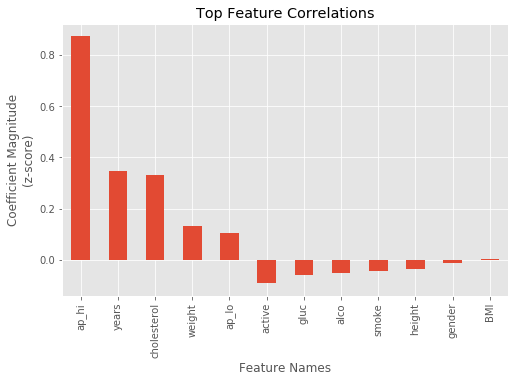

In [27]:
# Examine variables of interest  
import matplotlib.pyplot as plt
%matplotlib inline
#plt.rcParams.update({'font.size': 22})

#Plot the model's feature importances
# REFERENCE:  Eric Larson, https://github.com/eclarson/DataMiningNotebooks
plt.style.use('ggplot')

wt_plt_df = linreg_ft_imp_df.head(75)

weights = pd.Series(wt_plt_df['weights'].values,index=wt_plt_df['feature_names'])
ax = weights.plot(kind='bar', figsize=(8,5))

ax.set_title("Top Feature Correlations")
ax.set_ylabel("Coefficient Magnitude\n(z-score)")
ax.set_xlabel("Feature Names")
plt.show()

Text(0.5,0,'Coefficient Magnitude\n(z-score)')

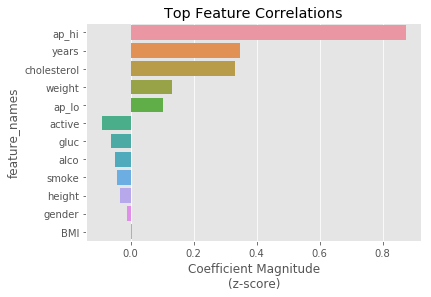

In [28]:
#drawing the coefficients with SNS
import seaborn as sns
ax = sns.barplot(x =linreg_ft_imp_df['weights'], y = linreg_ft_imp_df['feature_names'], orient= 'h')
ax.set_title("Top Feature Correlations")
ax.set_xlabel("Coefficient Magnitude\n(z-score)")

#### A4. Finding the most influential features by Recursive Feature Elimination method

In [29]:
from sklearn.feature_selection import RFECV

#Create a regression estimator with best parameters for cross validation
classifierEst = regGridSearch.best_estimator_

rfecv = RFECV(estimator=classifierEst, step=1, cv=cv, scoring='accuracy')
rfecv.fit(X_Scl, Y)

C:\Users\04616598\.conda\envs\ML7331\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


RFECV(cv=ShuffleSplit(n_splits=10, random_state=0, test_size=0.2, train_size=None),
      estimator=LogisticRegression(C=0.01, class_weight='balanced', dual=False,
                                   fit_intercept=True, intercept_scaling=1,
                                   l1_ratio=None, max_iter=100,
                                   multi_class='warn', n_jobs=None,
                                   penalty='l2', random_state=0, solver='lbfgs',
                                   tol=0.0001, verbose=0, warm_start=False),
      min_features_to_select=1, n_jobs=None, scoring='accuracy', step=1,
      verbose=0)

Optimal number of features : 11


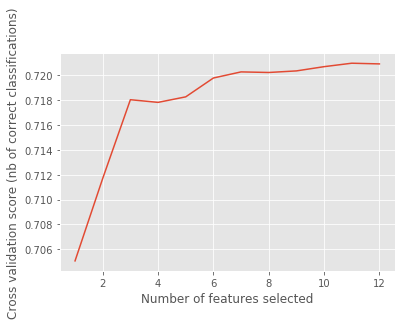

In [30]:
# Examine categorical variables of interest  
import matplotlib.pyplot as plt
%matplotlib inline

print("Optimal number of features : %d" % rfecv.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

In [31]:
#Plot the RFE Rankings
plt.style.use('ggplot')

rfe_ft_imp_df = pd.DataFrame({'feature_names':X.columns, 'weights':rfecv.grid_scores_})
rfe_ft_imp_df.sort_values(by='weights', inplace=True, ascending=False )

features = rfe_ft_imp_df

features

,feature_names,weights
10,years,0.720958
11,BMI,0.720902
9,active,0.720680
8,alco,0.720339
6,gluc,0.720260
7,smoke,0.720213
5,cholesterol,0.719768
4,ap_lo,0.718254
2,weight,0.718024
3,ap_hi,0.717810


#### A5. Combining everything together

In [32]:
#best-feature, scaling, cross-validation, GRID search
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import ShuffleSplit

#Use recursive feature elimination to get the best features for our model
#(We already did this earlier)

rfecv = RFECV(estimator=classifierEst, step=1, cv=cv, scoring='accuracy')
X_BestFeatures = rfecv.fit_transform(X, Y)

#create a pipeline to scale all of the data and perform logistic regression during each grid search step.
pipe = make_pipeline(StandardScaler(), LogisticRegression())

# Define a range of hyper parameters for grid search
parameters = { 'logisticregression__penalty':['l2']
              ,'logisticregression__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]
              ,'logisticregression__class_weight': ['balanced','none']
              ,'logisticregression__random_state': [0]
              ,'logisticregression__solver': ['lbfgs']
              ,'logisticregression__max_iter':[100,500]
             }

#Perform the grid search using accuracy as a metric during cross validation.
grid = GridSearchCV(pipe, parameters, cv=cv, scoring='accuracy')

#Use the best features from recursive feature elimination during the grid search
grid.fit(X_BestFeatures, np.ravel(Y))

#display the best pipeline model identified during the grid search
grid.best_estimator_

C:\Users\04616598\.conda\envs\ML7331\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\04616598\.conda\envs\ML7331\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\04616598\.conda\envs\ML7331\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\04616598\.conda\envs\ML7331\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\04616598\.conda\envs\ML7331\lib\site-packages\sklearn\linear_model\logis

C:\Users\04616598\.conda\envs\ML7331\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\04616598\.conda\envs\ML7331\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\04616598\.conda\envs\ML7331\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\04616598\.conda\envs\ML7331\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\04616598\.conda\envs\ML7331\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Incre

Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('logisticregression',
                 LogisticRegression(C=0.001, class_weight='balanced',
                                    dual=False, fit_intercept=True,
                                    intercept_scaling=1, l1_ratio=None,
                                    max_iter=100, multi_class='warn',
                                    n_jobs=None, penalty='l2', random_state=0,
                                    solver='lbfgs', tol=0.0001, verbose=0,
                                    warm_start=False))],
         verbose=False)

In [33]:
EvaluateClassifierEstimator(grid.best_estimator_, X_BestFeatures, np.ravel(Y), cv)

The average accuracy for all cv folds is: 			 0.7168
The average precision for all cv folds is: 			 0.75305
*********************************************************
Cross Validation Fold Mean Error Scores


,Accuracy,Precision
0,0.717548,0.749665
1,0.719768,0.763512
2,0.718975,0.744917
3,0.716835,0.761239
4,0.715011,0.756997
5,0.714773,0.751487
6,0.713425,0.745278
7,0.719689,0.756393
8,0.712711,0.751298
9,0.719293,0.749665


In [34]:
EvaluateClassifierEstimator2(grid.best_estimator_, X_BestFeatures, np.ravel(Y), 10)

              precision    recall  f1-score   support

           0       0.69      0.80      0.74     31969
           1       0.75      0.64      0.69     31086

    accuracy                           0.72     63055
   macro avg       0.72      0.72      0.72     63055
weighted avg       0.72      0.72      0.72     63055

[[25478  6491]
 [11312 19774]]
0.71765918642455


In [35]:
weights = grid.best_estimator_.named_steps['logisticregression'].coef_.ravel()
print(weights)

[ 0.90034743  0.33079559 -0.02966454 -0.05223282 -0.04949766 -0.08557622
  0.13074081]


In [36]:
#Looking at RFECV Feature Importance after using a Pipeline

#Load the model's coefficient weights and feature names into a dataframe sorted by weights
weights = grid.best_estimator_.named_steps['logisticregression'].coef_.ravel()

feature_names = X.columns.values[rfecv.get_support(indices=True)]
print(feature_names)
linreg_ft_imp_df = pd.DataFrame({'feature_names':feature_names, 'weights':weights, 'absolute_weights': np.abs(weights)})
linreg_ft_imp_df.sort_values(by='absolute_weights', inplace=True, ascending=False )

['ap_hi' 'cholesterol' 'gluc' 'smoke' 'alco' 'active' 'BMI']


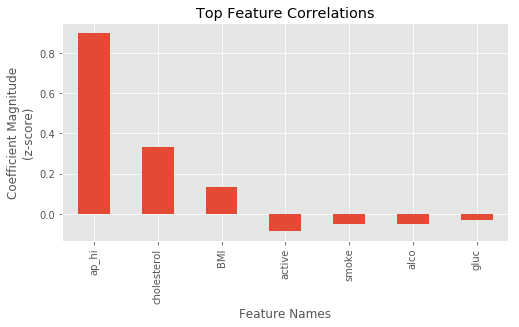

In [37]:
# Examine categorical variables of interest  
import matplotlib.pyplot as plt
%matplotlib inline

#Plot the model's feature importances
# REFERENCE:  Eric Larson, https://github.com/eclarson/DataMiningNotebooks
plt.style.use('ggplot')

wt_plt_df = linreg_ft_imp_df

weights = pd.Series(wt_plt_df['weights'].values,index=wt_plt_df['feature_names'])
ax = weights.plot(kind='bar', figsize=(8,4))

ax.set_title("Top Feature Correlations")
ax.set_ylabel("Coefficient Magnitude\n(z-score)")
ax.set_xlabel("Feature Names")
plt.show()

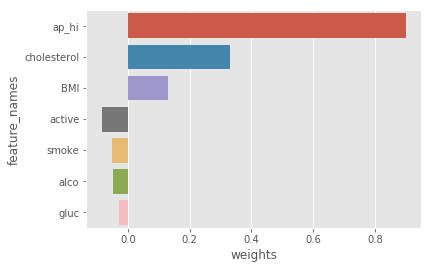

In [38]:
import seaborn as sns

sns.barplot(x =linreg_ft_imp_df['weights'], y = linreg_ft_imp_df['feature_names'], orient= 'h')

### B. SVM

#### B1.  Initial model build

In [39]:
#the following will generate matrix for X and Y
features = ["gender", "height", "weight", "ap_hi", "ap_lo", "cholesterol", "gluc", "smoke", "alco", "active", "years", "BMI"]
# Separating out the features
X = df.loc[:, features].values

#Separating out the target
Y = df.loc[:, ['cardio']].values


In [40]:
%%time
# Run through the cross validation loop and set the training and testing variable for one single iteration
from sklearn.svm import SVC
from sklearn import metrics as mt
from sklearn.model_selection import ShuffleSplit
cv = ShuffleSplit(n_splits=2, test_size=0.20, random_state=0)
scl_obj = StandardScaler()
svm_clf = SVC() # get object (C=0.5, kernel='linear', degree=3, gamma='auto')

for train_indices, test_indices in cv.split(X,Y): 
    # I will create new variables here so that it is more obvious what 
    # the code is doing (you can compact this syntax and avoid duplicating memory,
    # but it makes this code less readable)
    X_train = X[train_indices]
    Y_train = Y[train_indices]
    
    X_test = X[test_indices]
    Y_test = Y[test_indices] 
    
    X_train_scaled = scl_obj.fit_transform(X_train) # apply to training
    X_test_scaled = scl_obj.transform(X_test) 
    
    svm_clf.fit(X_train_scaled, Y_train)  # train object
    y_hat = svm_clf.predict(X_test_scaled) # get test set precitions
    acc = mt.accuracy_score(Y_test,y_hat)
    conf = mt.confusion_matrix(Y_test,y_hat)
    print('accuracy:', acc )
    print(conf)
    

C:\Users\04616598\.conda\envs\ML7331\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


accuracy: 0.7271429704226469
[[5103 1341]
 [2100 4067]]


C:\Users\04616598\.conda\envs\ML7331\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


accuracy: 0.7289667750376655
[[5039 1259]
 [2159 4154]]
Wall time: 3min 45s


Using default values for support vector machine (SVM) model, we obtained an accuracy value close to 73%. Can we increase the accuracy by optimizing the parameter value settings? However, the run time for SVM model is much longer than the value with Logistic regression. 

In [41]:
#check if there is a big difference in terms of fitting and transforming the test dataset or just transformaing
from sklearn.svm import SVC
from sklearn import metrics as mt
from sklearn.model_selection import ShuffleSplit
cv = ShuffleSplit(n_splits=1, test_size=0.20, random_state=0)
scl_obj = StandardScaler()
svm_clf = SVC(C=0.5, kernel='linear', degree=3, gamma='auto') # get object

for train_indices, test_indices in cv.split(X1,Y1): 
    # I will create new variables here so that it is more obvious what 
    # the code is doing (you can compact this syntax and avoid duplicating memory,
    # but it makes this code less readable)
    X1_train = X1[train_indices]
    Y1_train = Y1[train_indices]
    
    X1_test = X1[test_indices]
    Y1_test = Y1[test_indices] 
    
    X1_train_scaled = scl_obj.fit_transform(X1_train) # apply to training
    X1_test_scaled = scl_obj.fit_transform(X1_test) 
    
    svm_clf.fit(X1_train_scaled, Y1_train)  # train object
    y_hat = svm_clf.predict(X1_test_scaled) # get test set precitions
    acc = mt.accuracy_score(Y1_test,y_hat)
    conf = mt.confusion_matrix(Y1_test,y_hat)
    print('accuracy:', acc )
    print(conf)

NameError: name 'X1' is not defined

#### B2. Find the best SVM parameter settings

In [ ]:
#divide data into two parts X(features) and Y(target)
X = df_1[features].copy()

Y= df_1[['cardio']].copy()

#Divide data into test and training splits and having 10-fold CV
cv = ShuffleSplit(n_splits=10, test_size=0.20, random_state=0)

#data scaling
scaler = StandardScaler()
scaler.fit(X)

#Transform training data to z-scores
#This makes our model's coefficients take on the same scale for accurate feature importance analysis 
X_Scl = scaler.transform(X)

In [ ]:
%%time
#SVM 5-fold cross-validation 

svm_clf = SVC()

parameters = { 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]
              , 'kernal': ['linear', 'rbf']              
              ,'class_weight': ['balanced','none']
              ,'random_state': [0]
              ,'max_iter':[100]
             }

#Create a grid search object using the above parameters 
from sklearn.model_selection import GridSearchCV
regGridSearch = GridSearchCV(estimator=svm_clf
                   , n_jobs=8 # jobs to run in parallel
                   , verbose=1 # low verbosity
                   , param_grid=parameters
                   , cv=cv # KFolds = 5
                   , scoring='accuracy')

#Perform hyperparameter search to find the best combination of parameters for our data
regGridSearch.fit(X_Scl, Y)

In [ ]:
#Display the best estimator parameters
regGridSearch.best_estimator_

In [ ]:
#Use the best parameters for our Logistic Regression object
classifierEst = regGridSearch.best_estimator_

#Evaluate the regression estimator above using our pre-defined cross validation and scoring metrics. 
EvaluateClassifierEstimator(classifierEst, X_Scl, Y, cv)

In [ ]:
EvaluateClassifierEstimator2(classifierEst, X_Scl, Y, 10)

Because the SVM is too time-consuming, we decided to use SGDClassifier on SVM. 

In [ ]:
# now divide the data into test and train using scikit learn built-ins
from sklearn.model_selection import StratifiedShuffleSplit 
cv = StratifiedShuffleSplit( n_splits=2,test_size=0.2)

#the following will generate matrix for X and Y
features = ["gender", "height", "weight", "ap_hi", "ap_lo", "cholesterol", "gluc", "smoke", "alco", "active", "years", "BMI"]
# Separating out the features
X = df.loc[:, features].values

#Separating out the target
Y = df.loc[:, ['cardio']].values

In [ ]:
%%time
# use some compact notation for creating a linear SVM classifier with stochastic descent
from sklearn.linear_model import SGDClassifier
from sklearn import metrics as mt


regularize_const = 0.1
iterations = 5
svm_sgd = SGDClassifier(alpha=regularize_const,
        fit_intercept=True, l1_ratio=0.0, learning_rate='optimal',
        loss='hinge', n_jobs=-1, penalty='l2')

#n_iter=iterations

scl = StandardScaler()
for train_idx, test_idx in cv.split(X,Y):
    svm_sgd.fit(scl.fit_transform(X[train_idx]),Y[train_idx])
    yhat = svm_sgd.predict(scl.transform(X[test_idx]))
    
    conf = mt.confusion_matrix(Y[test_idx],yhat)
    acc = mt.accuracy_score(Y[test_idx],yhat)

print('SVM:', acc)

In [ ]:
%%time
# use some compact notation for creating a logistic regression classifier with stochastic descent
log_sgd = SGDClassifier(alpha=regularize_const,
        fit_intercept=True, l1_ratio=0.0, learning_rate='optimal',
        loss='log',  n_jobs=-1, penalty='l2')

#n_iter=iterations,

scl = StandardScaler()
for train_idx, test_idx in cv.split(X,Y):
    log_sgd.fit(scl.fit_transform(X[train_idx]),Y[train_idx])
    yhat = log_sgd.predict(scl.transform(X[test_idx]))
    
    conf = mt.confusion_matrix(Y[test_idx],yhat)
    acc = mt.accuracy_score(Y[test_idx],yhat)

print('Logistic Regression:', acc)

In [ ]:
%%time
# now lets use some of what we know from this class to reduce the dimensionality of the set
from sklearn.decomposition import PCA
n_components =6

pca = PCA(n_components=n_components, svd_solver='randomized')

iterations = 150
log_sgd = SGDClassifier(
        fit_intercept=True, l1_ratio=0.0, learning_rate='optimal',
        loss='log',  n_jobs=-1, penalty='l2')

#n_iter=iterations,

# you could also set this up in a pipeline
for train_idx, test_idx in cv.split(X,Y):
    log_sgd.fit(pca.fit_transform(X[train_idx]),Y[train_idx])
    yhat = log_sgd.predict(pca.transform(X[test_idx]))
    
    conf = mt.confusion_matrix(Y[test_idx],yhat)
    acc = mt.accuracy_score(Y[test_idx],yhat)

print('Logistic Regression:', acc)